In [648]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import matplotlib as mpl
import matplotlib.ticker as mticker

from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


# plot_confusion_matrix is a handy visual tool, added in the latest version of scikit-learn
# if you are running an older version, comment out this line and just use confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve, roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import StackingRegressor

import warnings
warnings.filterwarnings('ignore')


The main aim of our project is to find the probability that a person will receive H1N1 and seasonal Flu vaccination based on many parameters.
 The data obtained from the National 2009 H1N1 Flu Survey (NHFS) contains 3 CSV files namely the training set features, the training set labels, and the test set features.
We have considered various methodologies and compared different Machine Learning and Artificial Neural Network models to predict the required probability. 
The Machine Learning algorithms such as Linear regression, Support Vector Regression, Random Forest Regression, Logistic Regression, Ridge Regression, K Nearest Neighbors, and XGBoost were used.

My goal for this project was to build a classifier to predict the seasonal flu vaccination status (did not receive flu vaccine vs. did receive the vaccine). The main purpose of the model was to make these predictions as accurately as possible, while maximizing the recall for individuals who elect not to get the vaccine. By building an accurate model and focusing on those that don't get vaccinated, I can provide insights into which factors are most important in determining vaccination status and which subgroups of the population pro-vaccination efforts/ organizations should focus on most to maximize the benefits of herd immunity.

Data files were obtained from DrivenData (Source: CDC, NCRID and NCHS (2012), National 2009 H1N1 Flu Survey). They contain the results of a phone survey conducted in 2009 which collected some basic demogrpahic information as well as information specfic to an individual's risk of developing flu-related complications (such as having a chronic medical condition), and opinions regarding vaccination and risk. The survey focused on both the seasonal flu, as well as H1N1 flu that caused a global pandemic that year. The classifiers I built were meant to predict whether or not someone was vaccinated against the seasonal flu, but the models did include information about each respondent's knowledge and concern regarding H1N1 flu as this may have impacted their choice to get vaccinated against the seasonal flu. However, information regarding and individual's opinions about the H1N1 vaccine was not used. The choice to get vaccinated against the seasonal flu in the midst of a global pandemic of a virus that attacks the respiratory system is especially relevant today given the current COVID-19 pandemic.

Once the dataset was scrubbed and the initial set of features to use for predicting was finalized, the data were split into training and test sets for building and evaluating the performance of multiple types of classifiers. I built, tested, and attempted to tune classifiers in the following categories:

- Logistic Regression
- Decision Tree
- Random Forest
- XGradient Boosted

Each of the above was tuned using GridSearchCV to test combinations of hyperparameters. The top performing classifiers from each category (excluding the decision tree category which stuck out as having the worst performance with the test data) were used as estimators in a Stacking Classifier.

In [225]:
'''
## focus of problem is on seasonal flu vaccines, so information most specific to h1n1 won't be needed
# drop specific h1n1 cols from df
df.drop(columns=['opinion_h1n1_vacc_effective',
                 'opinion_h1n1_risk',
                 'opinion_h1n1_sick_from_vacc',
                 'doctor_recc_h1n1',
                 'h1n1_vaccine'], axis=1, inplace=True)
'''

"\n## focus of problem is on seasonal flu vaccines, so information most specific to h1n1 won't be needed\n# drop specific h1n1 cols from df\ndf.drop(columns=['opinion_h1n1_vacc_effective',\n                 'opinion_h1n1_risk',\n                 'opinion_h1n1_sick_from_vacc',\n                 'doctor_recc_h1n1',\n                 'h1n1_vaccine'], axis=1, inplace=True)\n"

In [658]:
# Read the Data
df = pd.read_csv("./Data/FullDataSet.csv")
df.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [659]:
df.shape

(26707, 38)

In [660]:
df.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation', 'h1n1_vaccine', 'seasonal_vaccine'],
      dtype='object')

#### Columns to drop:
- Since we are only interested in `seasonal_vaccine` as the target, let's drop the following  irrelevant columns:
    - `respondent_id` - redundant with index
    - `h1n1_vaccine`  - other target variable we are not addressing in this project
    - `h1n1_concern`
    - `h1n1_knowledge
    - `doctor_recc_h1n1`
    - `opinion_h1n1_vacc_effective`
    - `opinion_h1n1_sick_from_vacc`

In [661]:
df = df.drop(['respondent_id', 'h1n1_vaccine','h1n1_concern' ,'h1n1_knowledge' , 'doctor_recc_h1n1',
              'opinion_h1n1_vacc_effective' ,'opinion_h1n1_risk' ,'opinion_h1n1_sick_from_vacc'], axis = 1)     

In [363]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   behavioral_antiviral_meds    26636 non-null  float64
 1   behavioral_avoidance         26499 non-null  float64
 2   behavioral_face_mask         26688 non-null  float64
 3   behavioral_wash_hands        26665 non-null  float64
 4   behavioral_large_gatherings  26620 non-null  float64
 5   behavioral_outside_home      26625 non-null  float64
 6   behavioral_touch_face        26579 non-null  float64
 7   doctor_recc_seasonal         24547 non-null  float64
 8   chronic_med_condition        25736 non-null  float64
 9   child_under_6_months         25887 non-null  float64
 10  health_worker                25903 non-null  float64
 11  health_insurance             14433 non-null  float64
 12  opinion_seas_vacc_effective  26245 non-null  float64
 13  opinion_seas_ris

In [267]:
df.isnull().sum()
# There are many null values

behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
marital_status                  1408
rent_or_own                     2042
employment_status               1463
hhs_geo_region                     0
census_msa                         0
household_adults                 249
household_children               249
e

In [268]:
# Proportion of null values for the variables:
nulls = ((df.isnull().sum()*100) / len(df)).sort_values(ascending=False)
nulls[nulls > 0]

employment_occupation          50.436215
employment_industry            49.912008
health_insurance               45.957989
income_poverty                 16.561201
doctor_recc_seasonal            8.087767
rent_or_own                     7.645936
employment_status               5.477965
marital_status                  5.272026
education                       5.268282
chronic_med_condition           3.635751
child_under_6_months            3.070356
health_worker                   3.010447
opinion_seas_sick_from_vacc     2.010709
opinion_seas_risk               1.924589
opinion_seas_vacc_effective     1.729884
household_adults                0.932340
household_children              0.932340
behavioral_avoidance            0.778822
behavioral_touch_face           0.479275
behavioral_large_gatherings     0.325757
behavioral_outside_home         0.307036
behavioral_antiviral_meds       0.265848
behavioral_wash_hands           0.157262
behavioral_face_mask            0.071142
dtype: float64

* `employment_occupation`, `employment_industry`, and `health_insurance` and `income_poverty` columns contain the most missing values, with null values making up 50.4%, 49.9%, 46% and 16.6% of the column, respectively.
* But those demographic variables could be really important for the classification.
* At least let's try to impute some meaningful numbers for the null values of `health_insurance`: 

#### Dealing with nulls for `health_insurance`?:
- What other variable in the dataset health_insurance correlate with at the highest level?
- It seems like the majority of the people who had a doctor recommend them the vaccine, also had health insurance
- This makes sense given that those who go to the doctors usually have health insurance as well. 
- It also seems like the majority of those with a dcotor not recommending the vaccine alaso have health insurance. Although it is a t lower extent. 
- It would be hard to inmpute a value based ont his variable only.
- Ideally we shoudl have taken into considerancation all possibly relevant variables (such as income, race, education etc). to be able to make our best guess. 
- For this project I will treat the Null values as a seperate category thinking that it is a specifgic category of people who denied an answer to that question, since it does not feel like replacing them all with either 0 or 1. 
- Because nearly half (44.2%) of respondents declined to disclose whether they have health_insurance, this 'missing' information will become its own category for this variable.
- For the categorical variables: null values for these categorical variables will be filled with 'missing' as its own category since this missing information appears to represent a specific type of survey respondent.

In [326]:
corr = abs(df.corr()['health_insurance']).sort_values(ascending = False)
corr

health_insurance               1.000000
seasonal_vaccine               0.200858
doctor_recc_seasonal           0.117195
opinion_seas_vacc_effective    0.091247
household_adults               0.078697
household_children             0.069402
chronic_med_condition          0.066088
opinion_seas_sick_from_vacc    0.065886
behavioral_antiviral_meds      0.063988
behavioral_outside_home        0.061381
behavioral_large_gatherings    0.059000
opinion_seas_risk              0.050232
health_worker                  0.046680
behavioral_face_mask           0.040257
behavioral_avoidance           0.032662
behavioral_wash_hands          0.031919
child_under_6_months           0.026836
behavioral_touch_face          0.011024
Name: health_insurance, dtype: float64

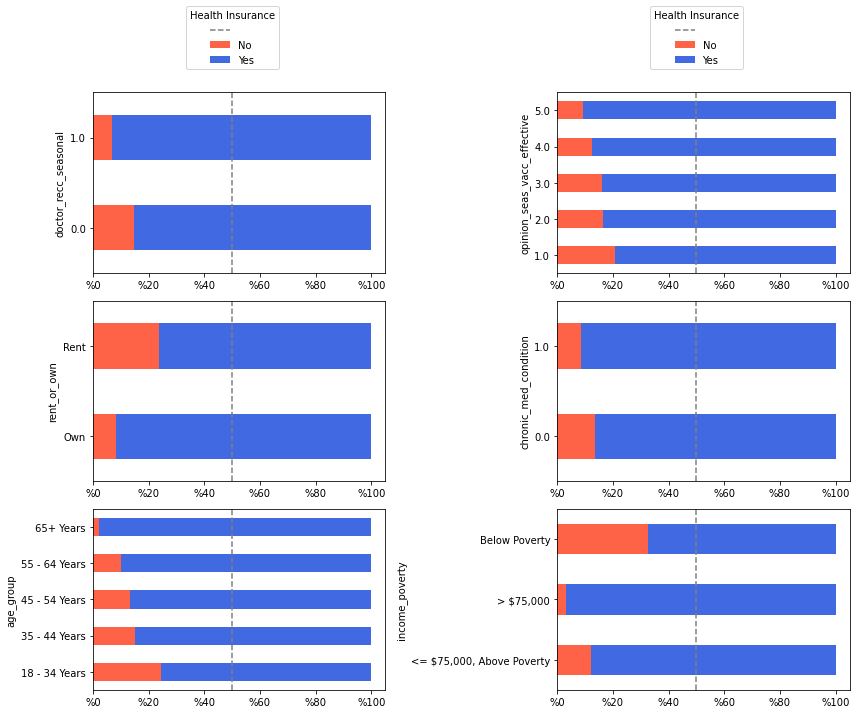

In [364]:
columns = ['doctor_recc_seasonal', 'opinion_seas_vacc_effective', 'rent_or_own', 'chronic_med_condition', 'age_group', 'income_poverty']

nrows = 3
ncols= 2

fig, ax_list = plt.subplots(nrows = nrows, ncols = ncols, figsize=(12,10))  

j=0
for i in range(nrows):
    for y in range(ncols):
        proportion_plot(columns[j], 'health_insurance', ax = ax_list[i,y]) # need to use index for column because otherwise it does not ititrate.
        j = j+1

ax_list[0, 0].legend(bbox_to_anchor=(0.3, 1.1), labels = [None, 'No', 'Yes'], title='Health Insurance')
ax_list[0, 1].legend(bbox_to_anchor=(0.3, 1.1), labels = [None, 'No', 'Yes'], title='Health Insurance')

fig.tight_layout();


In [395]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   behavioral_antiviral_meds    26636 non-null  float64
 1   behavioral_avoidance         26499 non-null  float64
 2   behavioral_face_mask         26688 non-null  float64
 3   behavioral_wash_hands        26665 non-null  float64
 4   behavioral_large_gatherings  26620 non-null  float64
 5   behavioral_outside_home      26625 non-null  float64
 6   behavioral_touch_face        26579 non-null  float64
 7   doctor_recc_seasonal         24547 non-null  float64
 8   chronic_med_condition        25736 non-null  float64
 9   child_under_6_months         25887 non-null  float64
 10  health_worker                25903 non-null  float64
 11  health_insurance             14433 non-null  float64
 12  opinion_seas_vacc_effective  26245 non-null  float64
 13  opinion_seas_ris

## A new data set to predict health_insurance:

In [491]:
df_insurance = df.dropna(subset = ['health_insurance'], axis=0)
df_insurance.shape

(14433, 30)

In [492]:
df_insurance['seasonal_vaccine'] =  df_insurance['seasonal_vaccine'].astype('float64')
df_insurance['health_insurance'] =  df_insurance['health_insurance'].astype('int64')
df_insurance['health_insurance'].dtype
df_insurance['health_insurance']

0        1
1        1
7        1
9        1
10       0
        ..
26699    1
26701    1
26703    1
26705    0
26706    1
Name: health_insurance, Length: 14433, dtype: int64

In [493]:
df_insurance.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14433 entries, 0 to 26706
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   behavioral_antiviral_meds    14386 non-null  float64
 1   behavioral_avoidance         14329 non-null  float64
 2   behavioral_face_mask         14422 non-null  float64
 3   behavioral_wash_hands        14415 non-null  float64
 4   behavioral_large_gatherings  14380 non-null  float64
 5   behavioral_outside_home      14384 non-null  float64
 6   behavioral_touch_face        14364 non-null  float64
 7   doctor_recc_seasonal         14069 non-null  float64
 8   chronic_med_condition        14300 non-null  float64
 9   child_under_6_months         14431 non-null  float64
 10  health_worker                14423 non-null  float64
 11  health_insurance             14433 non-null  int64  
 12  opinion_seas_vacc_effective  14403 non-null  float64
 13  opinion_seas_ris

In [494]:
X_insurance = df_insurance.drop('health_insurance', axis = 1)
y_insurance = df_insurance['health_insurance']
y_insurance

0        1
1        1
7        1
9        1
10       0
        ..
26699    1
26701    1
26703    1
26705    0
26706    1
Name: health_insurance, Length: 14433, dtype: int64

In [495]:
X_insurance = X_insurance[['doctor_recc_seasonal', 'opinion_seas_vacc_effective', 'rent_or_own', 'chronic_med_condition', 'age_group', 'income_poverty']]
y_insurance = df_insurance['health_insurance']
print(X_insurance.shape)
print(y_insurance.shape)

(14433, 6)
(14433,)


In [496]:
X_insurance_train_nums.columns

Index(['behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'opinion_seas_vacc_effective', 'opinion_seas_risk',
       'opinion_seas_sick_from_vacc', 'household_adults', 'household_children',
       'seasonal_vaccine'],
      dtype='object')

In [497]:
X_insurance_train, X_insurance_test, y_insurance_train, y_insurance_test = train_test_split(X_insurance, y_insurance,  random_state=42)

X_insurance_train_nums = X_insurance_train.select_dtypes('float64')
X_insurance_train_cats = X_insurance_train.select_dtypes('object')

In [498]:
numerical_preprocessing = Pipeline(steps=[
    ('simple_imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_preprocessing = Pipeline(steps=[
    ('simple_imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ohe', OneHotEncoder(drop='first', sparse=False))
])

preprocessor = ColumnTransformer(transformers=[  #grab columns out of a pandas data frame and then apply a specified transformer.
    ('num_preprocess', numerical_preprocessing, X_insurance_train_nums.columns),
    ('cat_preprocess', categorical_preprocessing, X_insurance_train_cats.columns)] # remainder='passthrough'
)

In [499]:
logreg_model_insurance = Pipeline([
    ("preprocessor", preprocessor),
    ("estimator", LogisticRegression(random_state=42)) # use random state so that your model results are reproducable. 
])

# Train model
logreg_model_insurance.fit(X_insurance_train, y_insurance_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_preprocess',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['doctor_recc_seasonal', 'opinion_seas_vacc_effective',
       'chronic_med_condition'],
      dtype='object')),
                                                 ('cat_preprocess',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                  



--------------------------------------------------------
Classification Report:
--------------------------------------------------------
              precision    recall  f1-score   support

           0      0.500     0.089     0.152      1298
           1      0.888     0.988     0.935      9526

    accuracy                          0.880     10824
   macro avg      0.694     0.539     0.544     10824
weighted avg      0.842     0.880     0.841     10824

--------------------------------------------------------
--------------------------------------------------------




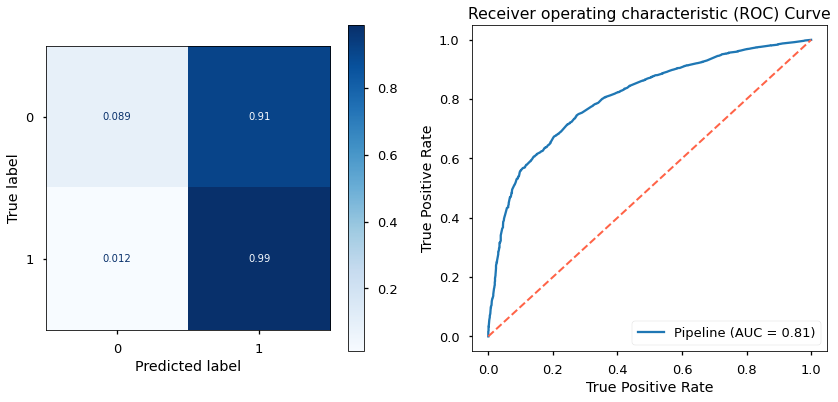

In [502]:
model_evaluation(logreg_model_insurance, X_insurance_train, y_insurance_train);



--------------------------------------------------------
Classification Report:
--------------------------------------------------------
              precision    recall  f1-score   support

           0      0.614     0.098     0.169       438
           1      0.888     0.991     0.937      3171

    accuracy                          0.883      3609
   macro avg      0.751     0.545     0.553      3609
weighted avg      0.855     0.883     0.844      3609

--------------------------------------------------------
--------------------------------------------------------




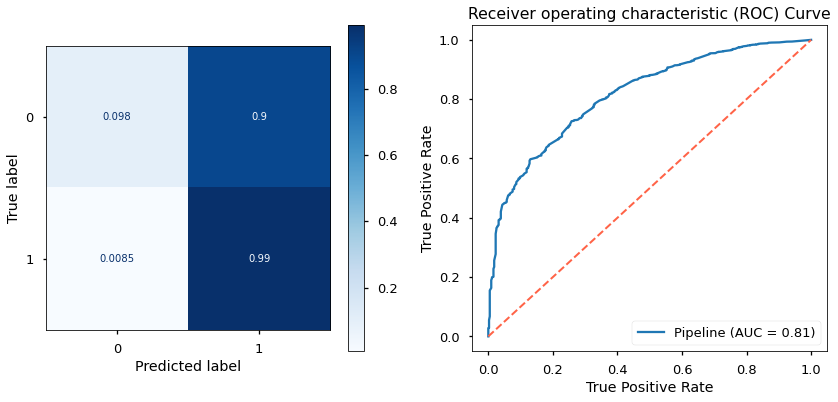

In [503]:
model_evaluation(logreg_model_insurance, X_insurance_test, y_insurance_test);

In [519]:
# Predict on test set using probabilities
predict_cat = logreg_model_insurance.predict(X_test) 
predict_cat = pd.DataFrame(predict_cat)
predict_cat
# It predicts almost all of them as 1!!!! Because majority is 1?

,0
0,1
1,1
2,1
3,1
4,1
...,...
6672,1
6673,1
6674,1
6675,1


In [270]:
# df['health_insurance_imputed'] = df['health_insurance']
# mask1 = ( df['health_insurance'].isnull() & (df['doctor_recc_seasonal'] == 1))
# mask2 = ( df['health_insurance'].isnull() & (df['doctor_recc_seasonal'] != 0))
# df.loc[mask1,'health_insurance_imputed'] = 1
# df.loc[mask2,'health_insurance_imputed'] = 0

In [271]:
# Convert health_insurance into a categorical variable so the null values would be of anoter categpry level
df['health_insurance'] = df['health_insurance'].astype("object")

# Replacing the string values with numerical values. 
dic = {0:'No', 1:'Yes'}
df.replace({"health_insurance": dic}, inplace=True)
df["health_insurance"].value_counts(dropna=False)

Yes    12697
NaN    12274
No      1736
Name: health_insurance, dtype: int64

In [272]:
df.describe()
# Many of the numerical variables appear as ordinal in nature. 

,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,seasonal_vaccine
count,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,24547.000000,25736.000000,25887.000000,25903.000000,26245.000000,26193.000000,26170.000000,26458.000000,26458.000000,26707.000000
mean,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,0.329735,0.283261,0.082590,0.111918,4.025986,2.719162,2.118112,0.886499,0.534583,0.465608
std,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,0.470126,0.450591,0.275266,0.315271,1.086565,1.385055,1.332950,0.753422,0.928173,0.498825
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2.000000,2.000000,1.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,5.000000,4.000000,4.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,5.000000,5.000000,3.000000,3.000000,1.000000


#### Is the target variable balanced or inbalanced? 
* Let's see the count values for those people who received and did not receive the seasonal vaccine:
* Based on below graph it appears as though the seasonal flu vaccine target has **balanced** classes. 

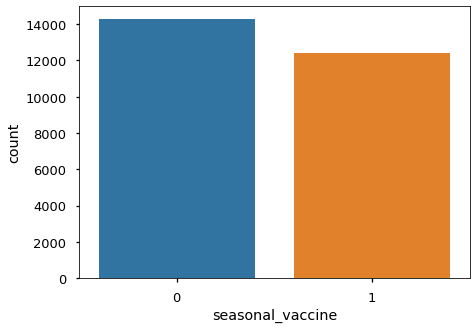

In [520]:
with plt.style.context('seaborn-talk'):
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.countplot(df['seasonal_vaccine'], ax= ax);

In [274]:
# Create a new df with cat codes - numbers - (temporarily) to see the distibution of all values using a histogram. 
df_cat = df
df_cat = df_cat.apply(lambda x: x.astype('category').cat.codes)

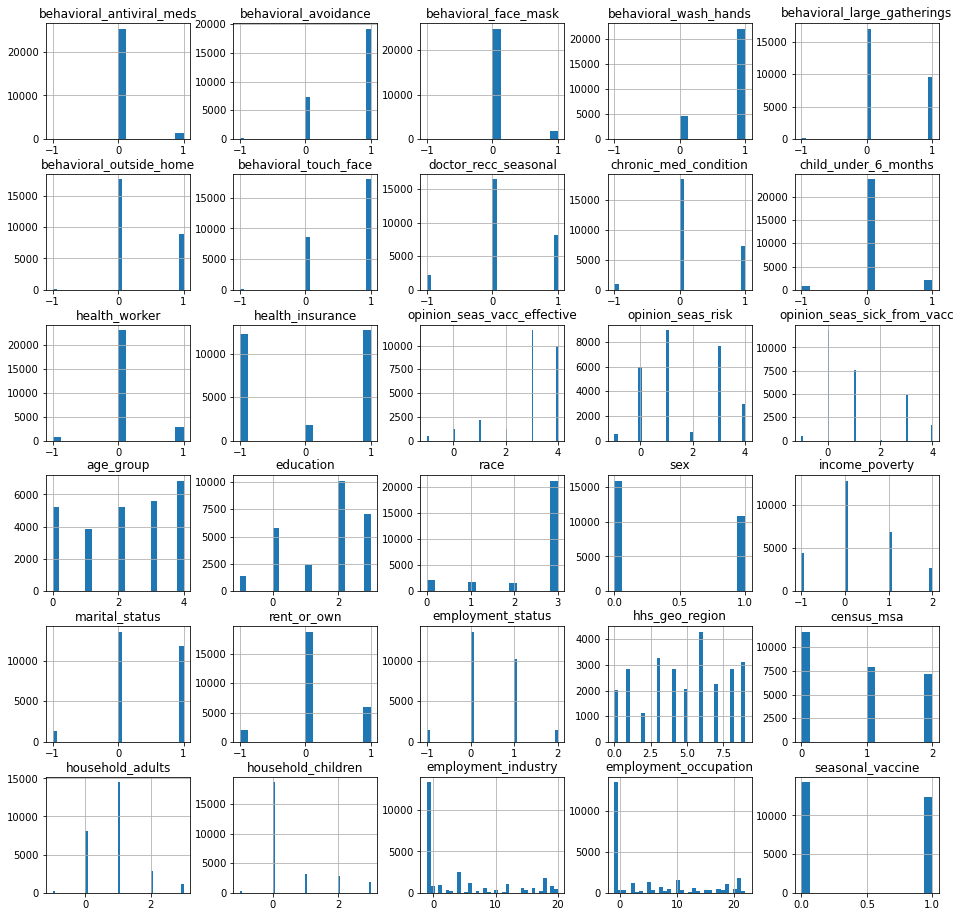

In [275]:
# Check out the distribution of all variables
df_cat.hist(bins='auto', edgecolor='none', figsize=(16,16));

In [276]:
df_cat.value_counts('employment_occupation').head()

employment_occupation
-1     13470
 21     1778
 10     1509
 5      1270
 2      1247
dtype: int64

* -1 represents null values and there are many variable with high number of null values. 
* All variables are appear as **categorical** in nature (possibly because the data was a survey data).
* The variables in float type will be treated as **ordinal** (no intrinsic ordering to its categories).
* The variables in object type will be treated as **nominal** (some sense of ordering to its categories). 


### Multicollinearity:
* Let's see how the variables correlate with one another. 
* Multicollinearity is not a big concern for logistic regression but if there are some variables that stand out with their high correlation we might choose to remove those variables: 


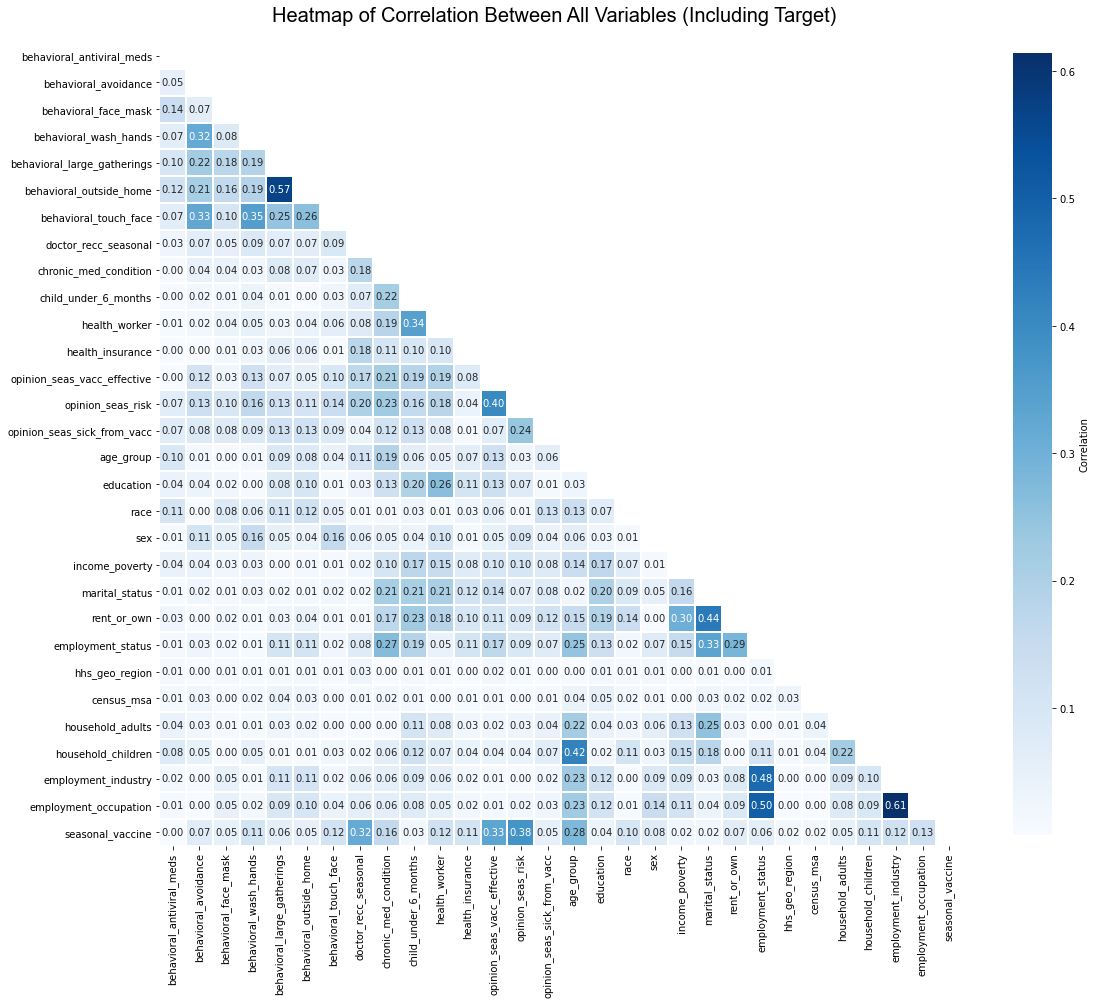

In [189]:
# Heat Map showing the correlation between all variables including the target
corr = df_cat.corr().abs()

fig, ax=plt.subplots(figsize=(18,18))
matrix = np.triu(corr) # Getting the Upper Triangle of the correlation matrix
cbar_kws={"label": "Correlation", "shrink":0.8}
heatmap = sns.heatmap(data = corr, cmap='Blues', linewidths = 1, square= True,  ax=ax, annot=True, mask=matrix, fmt= ".2f", cbar_kws=cbar_kws) 
fig.suptitle('Heatmap of Correlation Between All Variables (Including Target)', fontsize=20, y=.84, x = .43, fontname='Arial');
heatmap;

In [190]:
def show_corr_pairs(data):
    dataCorr = data.corr().abs()
    dataCorr = dataCorr.mask(np.triu(np.ones(dataCorr.shape)).astype(np.bool)) # convert upper triangle of values to NaN to remove repeated values from the table
    dataCorr = dataCorr.stack().reset_index().sort_values(0, ascending=False) #0 is the column automatically generated by the stacking
    dataCorr = dataCorr[(dataCorr[0]>.7) & (dataCorr[0]<1)]
    dataCorr =  dataCorr.rename(columns = {'level_0': 'var1', 'level_1': 'var2', 0:'corrcoef'})
    return dataCorr
show_corr_pairs(df_cat)

,var1,var2,corrcoef


### Let's see the proportion of people getting the vaccine at each level of each variable:
Similar idea taken from:
https://drivendata.co/blog/predict-flu-vaccine-data-benchmark/


* We will focus on one variable first to see how we can extract this information, and then generalize it to all variables

In [333]:
# Counts for getting / not getting the vaccine for each race:
counts = df[['race','seasonal_vaccine']].groupby(['race', 'seasonal_vaccine']).size().unstack('seasonal_vaccine')
counts

seasonal_vaccine,0,1
race,,
Black,1377,741
Hispanic,1159,596
Other or Multiple,935,677
White,10801,10421


In [334]:
# Getting the total numbers:
total_counts = counts.sum(axis=1)
total_counts

race
Black                 2118
Hispanic              1755
Other or Multiple     1612
White                21222
dtype: int64

In [335]:
# Getting the proportion of getting / not getting the vaccine for each race:
props = counts[[0,1]].multiply(100).div(total_counts, axis=0)  
props

seasonal_vaccine,0,1
race,,
Black,65.014164,34.985836
Hispanic,66.039886,33.960114
Other or Multiple,58.002481,41.997519
White,50.895297,49.104703


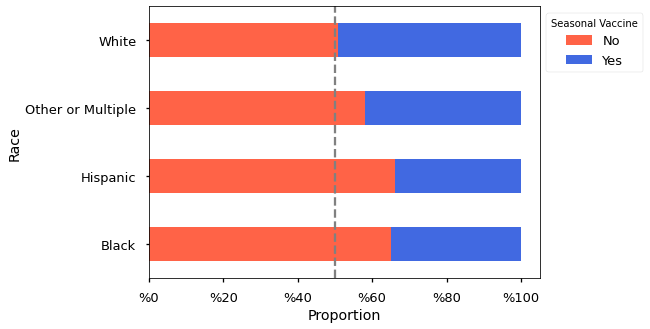

In [336]:
# Bar plot:
with plt.style.context('seaborn-talk'):
    fig, ax = plt.subplots(figsize=(7, 5))
    props.plot.barh(stacked=True, color = ['tomato','royalblue'], ax=ax)
    ax.legend(bbox_to_anchor=(1, 1), labels = ['No', 'Yes'], title='Seasonal Vaccine')
    ax.set_ylabel("Race")
    ax.set_xlabel("Proportion")
    ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('%{x:,.0f}')) 
    ax.axvline(x= 50, ymin=0, ymax=1, color='grey', linestyle='--') 

In [337]:
# Put this in a function so that we can loop it through each variable:

def proportion_plot(column, target, ax):  # if ax = None no axis sent and default is ax = None
    
    counts = df[[column,target]].groupby([column, target]).size().unstack(target)
    props = counts[[0,1]].multiply(100).div(counts.sum(axis=1), axis=0)  
    
    props.plot.barh(stacked=True, color = ['tomato','royalblue'], ax = ax)
    ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('%{x:,.0f}')) 
    ax.axvline(x= 50, ymin=0, ymax=1, color='grey', linestyle='--') 
    ax.legend().remove()

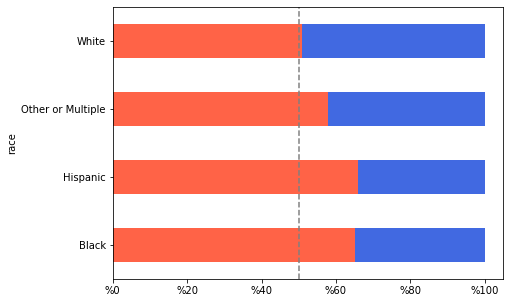

In [338]:
fig, ax = plt.subplots(figsize=(7,5))  
proportion_plot('race', 'seasonal_vaccine', ax);

In [339]:
len(df.columns)

30

IndexError: index 29 is out of bounds for axis 0 with size 29

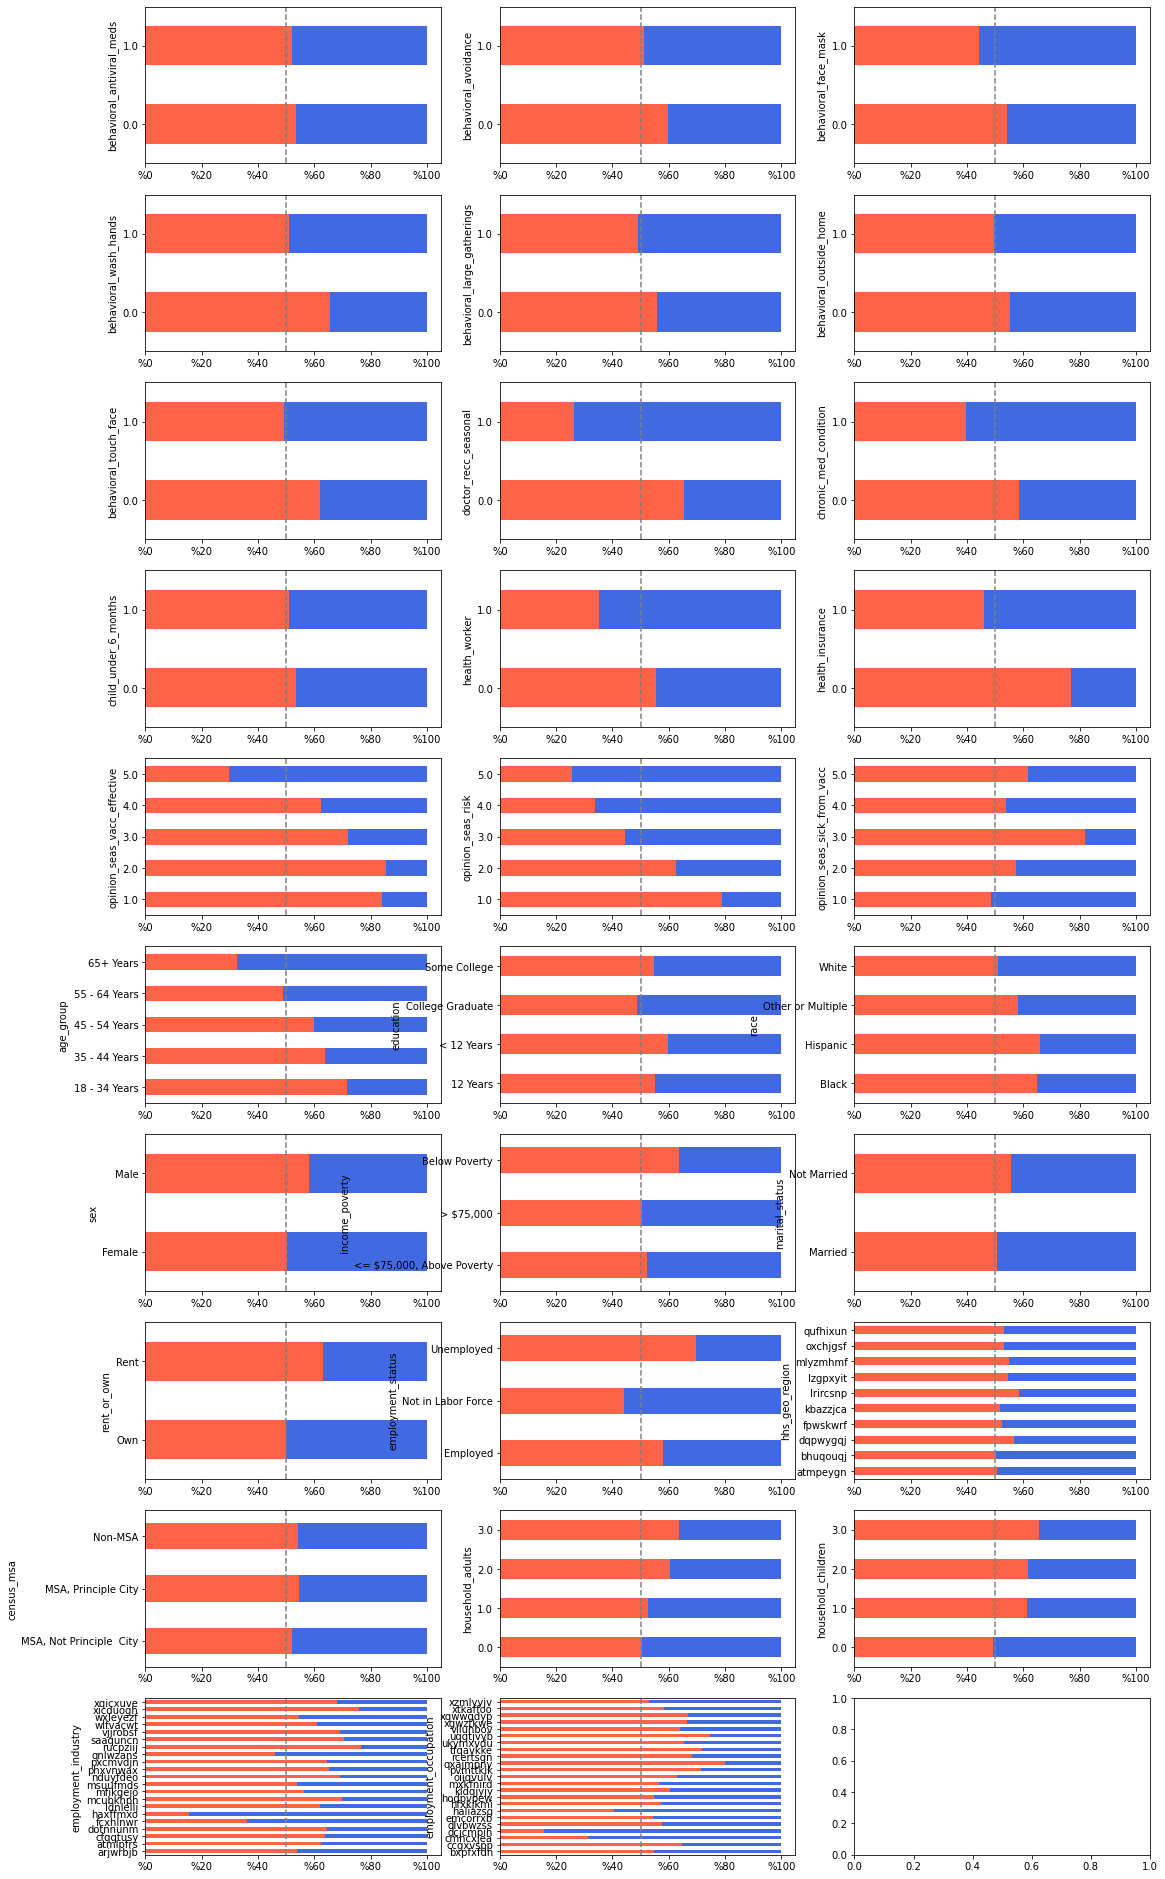

In [205]:
columns = df.columns.drop('seasonal_vaccine')

nrows = (len(df.columns)//3)
ncols= 3

fig, ax_list = plt.subplots(nrows = nrows, ncols = ncols, figsize=(18,34))  

j=0
for i in range(nrows):
    for y in range(ncols):
        proportion_plot(columns[j], 'seasonal_vaccine', ax = ax_list[i,y]) # need to use index for column because otherwise it does not ititrate.
        j = j+1

ax_list[0, 0].legend(bbox_to_anchor=(0.3, 1.1), labels = [None, 'No', 'Yes'], title='Seasonal Vaccine')
ax_list[0, 1].legend(bbox_to_anchor=(0.3, 1.1), labels = [None, 'No', 'Yes'], title='Seasonal Vaccine')
ax_list[0, 2].legend(bbox_to_anchor=(0.3, 1.1), labels = [None, 'No', 'Yes'], title='Seasonal Vaccine')

fig.tight_layout();

In [525]:
df['health_insurance'].median()

1.0

### Specify X and y:

In [526]:
X = df.drop('seasonal_vaccine', axis=1)
y = df['seasonal_vaccine']

### Test Train split the data:

In [527]:
X_train, X_test, y_train, y_test = train_test_split(X, y,  random_state=42)

X_train_nums = X_train.select_dtypes('float64')
X_train_cats = X_train.select_dtypes('object')

In [528]:
X_train_nums.columns

Index(['behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_seas_vacc_effective', 'opinion_seas_risk',
       'opinion_seas_sick_from_vacc', 'household_adults',
       'household_children'],
      dtype='object')

In [529]:
X_train_cats.columns

Index(['age_group', 'education', 'race', 'sex', 'income_poverty',
       'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation'],
      dtype='object')

In [530]:
assert ((len(X_train_nums.columns) + len(X_train_cats.columns)) == len(X.columns))

# Logistic Regression:

## Preprocessing Steps:
- **NA imputation** for both ordinal/numerical and categorical variables
    * For the ordinal variables, let's impute with the median.
    * For the categorical variables, let's impute with the most frequent. 
- **One-Hot-Encoding** for the categorical variables
- **Scaling** for the ordinal/numerical variables

### "Preprocessing" pipeline for the numerical/ordinal and categorical/nominal columns:

In [662]:
numerical_preprocessing = Pipeline(steps=[
    ('simple_imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_preprocessing = Pipeline(steps=[
    ('simple_imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ohe', OneHotEncoder(drop='first', sparse=False))
])

preprocessor = ColumnTransformer(transformers=[  #grab columns out of a pandas data frame and then apply a specified transformer.
    ('num_preprocess', numerical_preprocessing, X_train_nums.columns),
    ('cat_preprocess', categorical_preprocessing, X_train_cats.columns)] # remainder='passthrough'
)

### Model pipeline:

In [663]:
logreg_model = Pipeline([
    ("preprocessor", preprocessor),
    ("estimator", LogisticRegression(random_state=42)) # use random state so that your model results are reproducable. 
])

# Train model
logreg_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_preprocess',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavior...
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ohe',
               

In [664]:
# The data frame after preprocessing:
cat_feature_names = preprocessor.named_transformers_['cat_preprocess'].named_steps['ohe'].get_feature_names(X_train_cats.columns)
feature_names = np.r_[X_train_nums.columns, cat_feature_names]

X_train_transformed = pd.DataFrame(preprocessor.fit_transform(X_train), columns= feature_names)
X_train_transformed

,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,...,employment_occupation_qxajmpny,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv
0,-0.226446,-1.629246,-0.274025,-2.161995,-0.744662,-0.71286,-1.444234,-0.664084,-0.614937,-0.293742,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.226446,0.613781,-0.274025,0.462536,-0.744662,-0.71286,-1.444234,1.505834,1.626182,3.404345,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.226446,-1.629246,-0.274025,-2.161995,-0.744662,-0.71286,-1.444234,-0.664084,-0.614937,-0.293742,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.226446,-1.629246,-0.274025,-2.161995,-0.744662,-0.71286,-1.444234,-0.664084,1.626182,-0.293742,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.416054,0.613781,-0.274025,0.462536,1.342892,1.40280,0.692409,1.505834,-0.614937,-0.293742,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20025,-0.226446,-1.629246,-0.274025,0.462536,-0.744662,-0.71286,0.692409,-0.664084,-0.614937,-0.293742,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20026,-0.226446,-1.629246,-0.274025,0.462536,-0.744662,-0.71286,0.692409,-0.664084,-0.614937,-0.293742,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20027,-0.226446,0.613781,-0.274025,-2.161995,-0.744662,-0.71286,0.692409,-0.664084,-0.614937,-0.293742,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
20028,-0.226446,0.613781,-0.274025,0.462536,-0.744662,-0.71286,0.692409,1.505834,1.626182,-0.293742,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### The ROC curve can be used to determine an appropriate cut-off, affecting the sensitivity and specificity of the test. Can it be used for ML techniques too? to see precision -recall tradeoff?

### IS auc score The Area Under the Curve (AUC) more like an accuracy measure? 

### Then there is cross validated accuracy and log_loss values. 

### Which ones to rely on?

In [720]:
def model_evaluation(model, X, y):
    with plt.style.context('seaborn-talk'):
        fig, (ax1, ax2) = plt.subplots(ncols=2,  figsize=(14, 6))
        
        # Plot confusion matrix
        plot_confusion_matrix(model, X, y, ax=ax1, normalize = 'true', cmap = 'Blues'); # normalize = true, because we want to see recall more easily
        ax1.grid(False) 

        # plot Roc curve
        plot_roc_curve(model, X, y, ax=ax2)
        ax2.plot([0, 1], [0, 1], color='tomato', lw=2, linestyle='--')
        ax2.set_xlabel('False Positive Rate')
        ax2.set_ylabel('True Positive Rate')
        ax2.set_title('Receiver operating characteristic (ROC) Curve')
        
        # Print classification Scores
        true = y
        pred = model.predict(X)
        divider = ('----' * 14) 
        table_title = 'Classification Report:'
        table = classification_report(true, pred, digits=3)
        print('\n', divider, table_title, divider, table, divider, divider, '\n' , sep='\n') 
        
        # Find Scores
 
        true = y
        pred = model.predict(X)
        pred_proba = model.predict_proba(X)[:, 1]
        
        roc_score = roc_auc_score(true, pred_proba)
        precision = precision_score(true, pred)
        recall = recall_score(true, pred)
        accuracy = accuracy_score(true, pred)
        f1 = f1_score(true, pred)
        
        # Print Scores
        divider = ('----' * 6) 
        scores_title = 'Summary Scores for being Classified as Getting the Vaccine:'
        scores_table = {'Roc_Auc': [roc_score], 'Precision': [precision],'Recall':[recall], 'Accuracy': [accuracy], 'F1':[f1]}
        scores_table = pd.DataFrame.from_dict(scores_table, orient='index')
        scores_table.columns = ['Scores']
        print('\n', divider, scores_title, divider, scores_table, divider, divider, '\n' , sep='\n') 
        
        print(precision_recall_fscore_support(true, pred, average='macro'))





--------------------------------------------------------
Classification Report:
--------------------------------------------------------
              precision    recall  f1-score   support

           0      0.784     0.809     0.796     10638
           1      0.775     0.747     0.761      9392

    accuracy                          0.780     20030
   macro avg      0.780     0.778     0.779     20030
weighted avg      0.780     0.780     0.780     20030

--------------------------------------------------------
--------------------------------------------------------




------------------------
Summary Scores for being Classified as Getting the Vaccine:
------------------------
             Scores
Roc_Auc    0.854229
Precision  0.775420
Recall     0.747019
Accuracy   0.779930
F1         0.760954
------------------------
------------------------


(0.7795329742214614, 0.778002695489443, 0.7785345777289046, None)


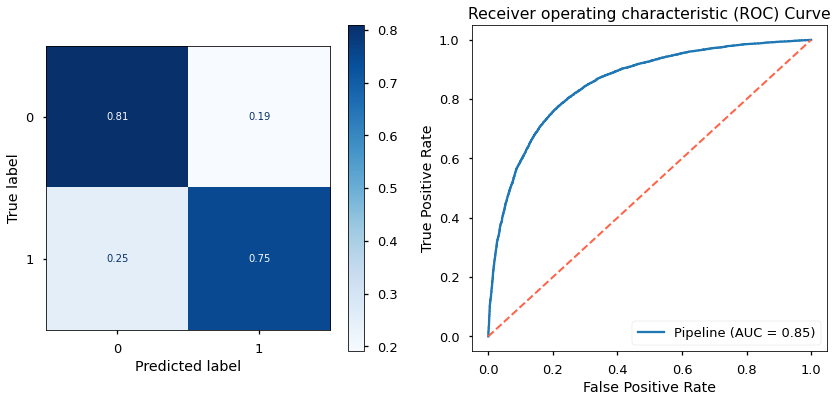

In [721]:
model_evaluation(logreg_model, X_train, y_train);

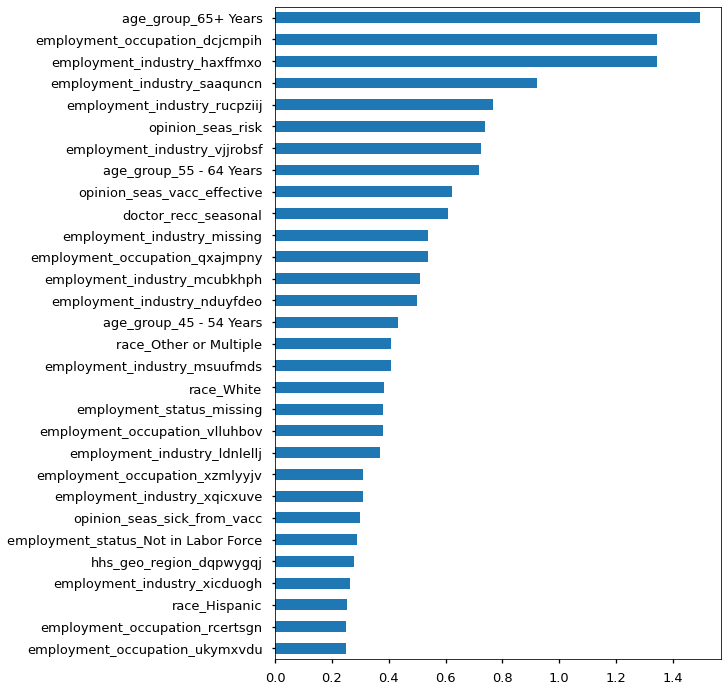

In [667]:
# logreg_model = name of the model pipeline
# estimator = name of the estimator in the pipeline

def feature_importance_logreg(model):
    logreg_coeffs = model.named_steps['estimator'].coef_ 
    importance = pd.Series(abs(logreg_coeffs[0]), index=feature_names) # logreg_coeffs[0] = getting the one-dim list inside the list
    with plt.style.context('seaborn-talk'):
        fig, ax = plt.subplots(figsize=(8,12))
        importance.sort_values().tail(30).plot.barh(ax=ax);
        
feature_importance_logreg(logreg_model)


In [83]:
# print(f"Seasonal Vaccine: AUC = {roc_auc_score(y_test, y_preds):.4f}")
# the best or optimal threshold for the classifier
# Prediction < 0.5 = Class 0
# Prediction >= 0.5 = Class 1

# Do you need AUC or accuracy scores to compare models? Accuracy is not a good measure if your data is inbalanced (accuracy will be high regardless) OR you care about recall versus precision, one more than the other. Learn what AUC really represents, it is a probability.   

# HOW TO FIND MOST OPTIMAL FALSE POSITIVE RATE?

# In the end either get ROC and confusion matrix OR CLASSIFICATION REPORT
# Get those for both train and test sets to make sure the model is not underfitting/overfitting. 
# If you get ROC draw the curve from different models on the same plot. 

#### Hyperparameters for logistic regression:
* **penalty** — Specify the norm of the penalty.
* **C** — Inverse of regularization strength; smaller values specify stronger regularization.
* **solver** — Algorithm to use in the optimization problem.
* **max_iter** — Maximum number of iterations taken for the solvers to converge.


## Gridsearch gives the best model already, and no need to refit the model using best paramaters?

## Parameter Tuning with GridSearchCV

In [576]:
# Parameter Grid
# There should be two underscores between estimator name and it's parameters in a Pipeline

parameters = {
    'estimator__penalty' : ['l1','l2'], 
    'estimator__fit_intercept':[True, False],
    'estimator__C'       : [0.001,0.01,0.1,1,10,100,1000], #np.logspace(-3,3,7)
    'estimator__solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

# Create the grid, with "logreg_pipeline" as the estimator
gridsearch = GridSearchCV(estimator =logreg_model,    # model
                          param_grid =parameters,     # hyperparameters
                          scoring ='recall_macro',          # metric for scoring
                          cv =5)                      # number of folds for cross-validation

# Train the pipeline (tranformations & predictor)
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num_preprocess',
                                                                         Pipeline(steps=[('simple_imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavi...
       'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation'],
   

In [750]:
print("Tuned Hyperparameters :", gridsearch.best_params_)

Tuned Hyperparameters : {'estimator__C': 100, 'estimator__fit_intercept': True, 'estimator__penalty': 'l1', 'estimator__solver': 'liblinear'}




--------------------------------------------------------
Classification Report:
--------------------------------------------------------
              precision    recall  f1-score   support

           0      0.783     0.809     0.796     10638
           1      0.776     0.746     0.761      9392

    accuracy                          0.780     20030
   macro avg      0.779     0.778     0.778     20030
weighted avg      0.780     0.780     0.780     20030

--------------------------------------------------------
--------------------------------------------------------




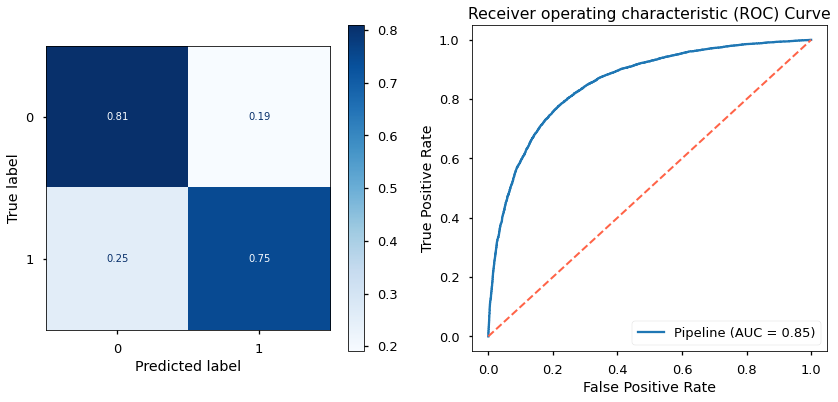

In [578]:
model_evaluation(gridsearch.best_estimator_, X_train, y_train);

In [378]:
# print out the tuned-hyperparameters as well as the training accuracy

# Return set of parameters with the best performance

# Return the performance metric score
print("Training Accuracy:", gridsearch.best_score_)
# Calculate the score on test data
print("Test Accuracy:", gridsearch.score(X_test, y_test))

Tuned Hyperparameters : {'estimator__C': 0.1, 'estimator__fit_intercept': True, 'estimator__penalty': 'l2', 'estimator__solver': 'liblinear'}
Training Accuracy: 0.7777333999001498
Test Accuracy: 0.7856821926014678


## GRID SEARCH FINDS THE BEST PAPARMETERS TO MAXIMIZE ACCURACY, BUT IT ALSO USES 5 FOLD CROSS-VALIDATION, SO IS gridsearch.best_score_ THE MEAN OF THE 5 FOLDS OR THE MAX OF THE 5 FOLDS?

## If it is the mean, it makes sense to look into test score as a direct comparison? But use 5 fold validation again?

## Is cross val more about model tuning, and test-train accuracy more about comparing different models with different methods?? 

In [299]:
logreg_pipeline_best = Pipeline([
    ("preprocessor", preprocessor),
    ("estimator", LogisticRegression(C=1, fit_intercept=False, penalty='l1', solver='liblinear', random_state=42))
])
    
logreg_pipeline_best.fit(X_train, y_train)

# Perform k-fold cross validation cross-validation with accuracy
scores = cross_val_score(estimator=logreg_pipeline_best, X=X_train,  y=y_train, cv=5).mean()
print(f"Mean Cross Validation Score: {scores :.4%}")

# Perform k-fold cross validation cross-validation with accuracy
scores = cross_val_score(estimator=logreg_pipeline_best, X=X_test,  y=y_test, cv=5).mean()
print(f"Mean Cross Validation Score: {scores :.4%}")

Mean Cross Validation Score: 77.7833%
Mean Cross Validation Score: 77.9840%


## Ignore log_loss for the project?

In [ ]:
# Perform cross-validation with log_loss
log_loss = -cross_val_score(estimator=logreg_pipeline, X=X_train, y=y_train, cv=5, scoring="neg_log_loss").mean()
log_loss

In [ ]:
# Perform k-fold cross validation cross-validation with accuracy
scores = cross_val_score(estimator=logreg_pipeline, X=X_train,  y=y_train, cv=5).mean()
print(f"Mean Cross Validation Score: {scores :.2%}")

In [ ]:
# Predict using the pipeline (includes the transfomers & trained predictor)
predicted = gridsearch.predict(X_test)
predicted

In [ ]:
with plt.style.context('seaborn-talk'):
    fig, ax = plt.subplots(figsize=(7, 7))
    plt.grid(False)
    plot_confusion_matrix(gridsearch, X_train, y_train, ax=ax);


### Start with all parameters?
### Parameter tuning did not make much difference, remnove variables?

In [ ]:
# With the values of the hyperparameters returned by the GridSearchCV() function, 
# you can now use these values to build your model using the training dataset:
logreg_pipeline_best = Pipeline([
    ("preprocessor", preprocessor),
    ("estimator", LogisticRegression(C=0.1, penalty='l2', solver='liblinear', random_state=42))
])
logreg_pipeline_best.fit(X_train, y_train)
y_pred = logreg_pipeline_best.predict(X_test)
print("Accuracy:",logreg_pipeline_best.score(X_test, y_test))    

In [719]:
from sklearn.metrics import precision_recall_fscore_support
y_true = np.array(['cat', 'dog', 'pig', 'cat', 'dog', 'pig'])
y_pred = np.array(['cat', 'pig', 'dog', 'cat', 'cat', 'dog'])
precision_recall_fscore_support(y_true, y_pred, average='macro')

(0.2222222222222222, 0.3333333333333333, 0.26666666666666666, None)

In [65]:
## You can use voting at the end!!! 

In [374]:
# Predict on test set using probabilities
predict_cat = logreg_pipeline.predict(X_test) 
print(predict_cat)
preds = logreg_pipeline.predict_proba(X_test)
preds

[0 0 1 ... 0 0 1]


array([[0.78026967, 0.21973033],
       [0.81746699, 0.18253301],
       [0.13929558, 0.86070442],
       ...,
       [0.67083071, 0.32916929],
       [0.59538476, 0.40461524],
       [0.1706102 , 0.8293898 ]])

In [375]:
# What is the probability that the person would get the vaccine, target =1:
y_preds = pd.DataFrame(
    {"seasonal_vaccine": preds[:,1]}, index = y_test.index
)
print("y_preds.shape:", y_preds.shape)
y_preds.head()

y_preds.shape: (6677, 1)


,seasonal_vaccine
15772,0.219730
9407,0.182533
16515,0.860704
23353,0.226891
10008,0.250274


## KNN neighbours

In [722]:
knn_model = Pipeline([
    ("preprocessor", preprocessor),
    ('knn', KNeighborsClassifier()) # use random state so that your model results are reproducable. 
])

# Train model
knn_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_preprocess',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavior...
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
    



--------------------------------------------------------
Classification Report:
--------------------------------------------------------
              precision    recall  f1-score   support

           0      0.823     0.812     0.817     10638
           1      0.790     0.802     0.796      9392

    accuracy                          0.807     20030
   macro avg      0.807     0.807     0.807     20030
weighted avg      0.808     0.807     0.807     20030

--------------------------------------------------------
--------------------------------------------------------




------------------------
Summary Scores for being Classified as Getting the Vaccine:
------------------------
             Scores
Roc_Auc    0.890745
Precision  0.790164
Recall     0.802279
Accuracy   0.807389
F1         0.796175
------------------------
------------------------


(0.8066026643700523, 0.8070896340719346, 0.8068041277073512, None)


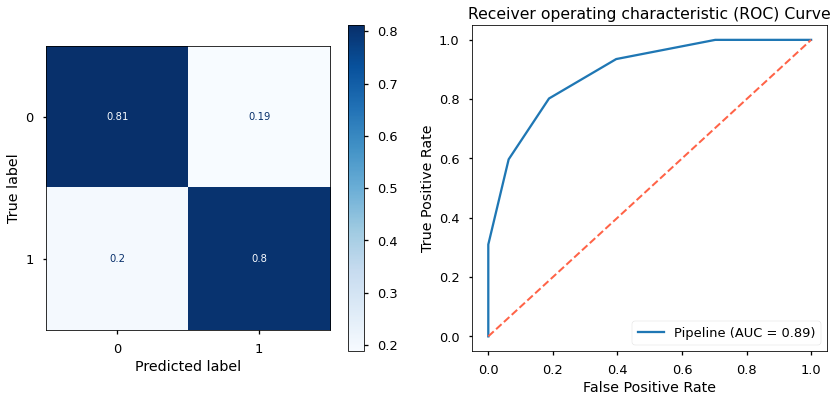

In [723]:
model_evaluation(knn_model, X_train, y_train);



--------------------------------------------------------
Classification Report:
--------------------------------------------------------
              precision    recall  f1-score   support

           0      0.758     0.725     0.741      3634
           1      0.688     0.724     0.705      3043

    accuracy                          0.724      6677
   macro avg      0.723     0.724     0.723      6677
weighted avg      0.726     0.724     0.725      6677

--------------------------------------------------------
--------------------------------------------------------




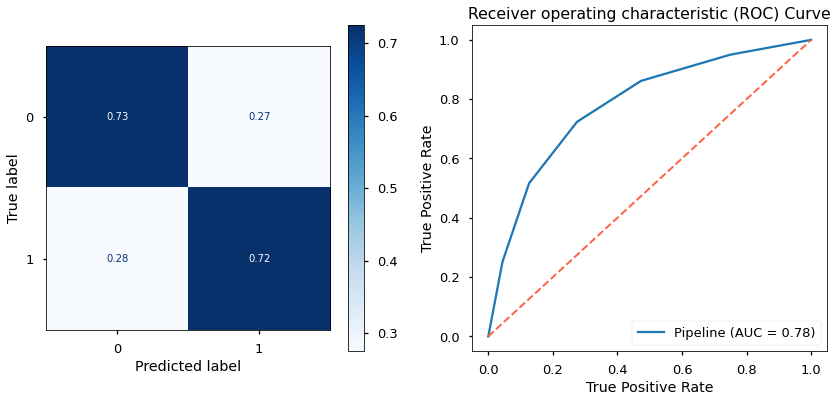

In [537]:
model_evaluation(knn_model, X_test, y_test);

In [727]:
y_pred = knn_model.predict_proba(X_test)[:, 1]
y_pred

array([0.4, 0.6, 1. , ..., 0.4, 0.2, 0.8])

In [736]:
knn_model.score[X_train, y_train]

TypeError: 'function' object is not subscriptable

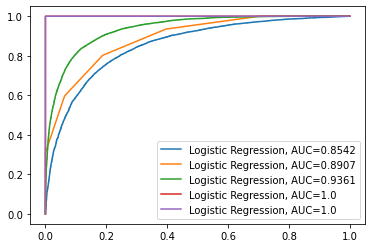

In [752]:
#set up plotting area
plt.figure(0).clf()
for model in [logreg_model, knn_model, xgb_model, rf_clf_model, RF_model]:

#fit logistic regression model and plot ROC curve
# model = LogisticRegression()
# model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_train)[:, 1]
    fpr, tpr, _ = roc_curve(y_train, y_pred)
    auc = round(roc_auc_score(y_train, y_pred), 4)
    plt.plot(fpr,tpr,label="Logistic Regression, AUC="+str(auc))

plt.legend()

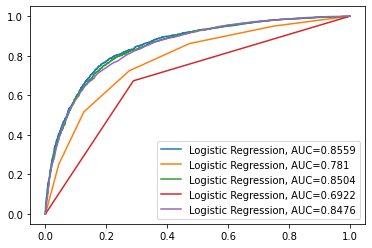

In [753]:
#set up plotting area
plt.figure(0).clf()
for model in [logreg_model, knn_model, xgb_model, rf_clf_model, RF_model]:

#fit logistic regression model and plot ROC curve
# model = LogisticRegression()
# model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc = round(roc_auc_score(y_test, y_pred), 4)
    plt.plot(fpr,tpr,label="Logistic Regression, AUC="+str(auc))

plt.legend()

In [725]:
from sklearn.metrics import roc_curve, auc
# Calculate the probability scores of each point in the training set
y_train_score = knn_model.decision_function(X_train)
# Calculate the fpr, tpr, and thresholds for the training set
train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score)
# Calculate the probability scores of each point in the test set
y_test_score = knn_model.decision_function(X_test)
# Calculate the fpr, tpr, and thresholds for the test set
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)

AttributeError: 'KNeighborsClassifier' object has no attribute 'decision_function'

In [ ]:
plt.figure(figsize=(10, 8))
lw = 2

plt.plot(train_fpr, train_tpr, color='blue',
         lw=lw, label='Train ROC curve')
plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='Test ROC curve')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [745]:
rf_clf_model = Pipeline([
    ("preprocessor", preprocessor),
    ('rf_clf', DecisionTreeClassifier(random_state= 42)) # use random state so that your model results are reproducable. 
])

# Train model
rf_clf_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_preprocess',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavior...
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ohe',
               



--------------------------------------------------------
Classification Report:
--------------------------------------------------------
              precision    recall  f1-score   support

           0      0.784     0.810     0.797     10638
           1      0.776     0.747     0.761      9392

    accuracy                          0.780     20030
   macro avg      0.780     0.778     0.779     20030
weighted avg      0.780     0.780     0.780     20030

--------------------------------------------------------
--------------------------------------------------------




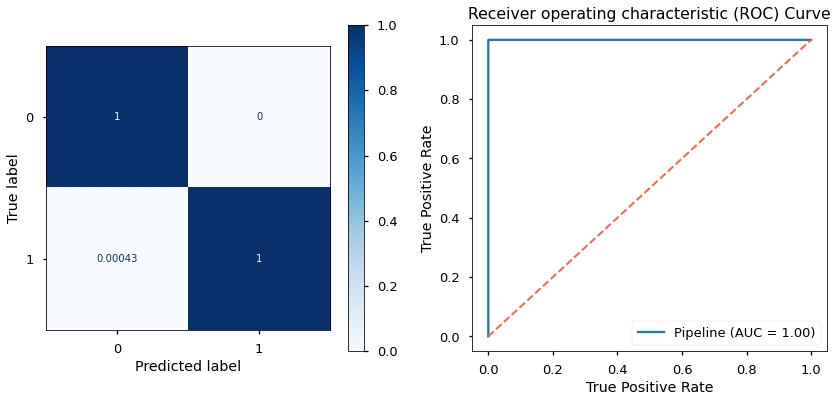

In [310]:
model_evaluation(rf_clf_model, X_train, y_train);



--------------------------------------------------------
Classification Report:
--------------------------------------------------------
              precision    recall  f1-score   support

           0      0.798     0.821     0.809      3634
           1      0.778     0.751     0.765      3043

    accuracy                          0.789      6677
   macro avg      0.788     0.786     0.787      6677
weighted avg      0.789     0.789     0.789      6677

--------------------------------------------------------
--------------------------------------------------------




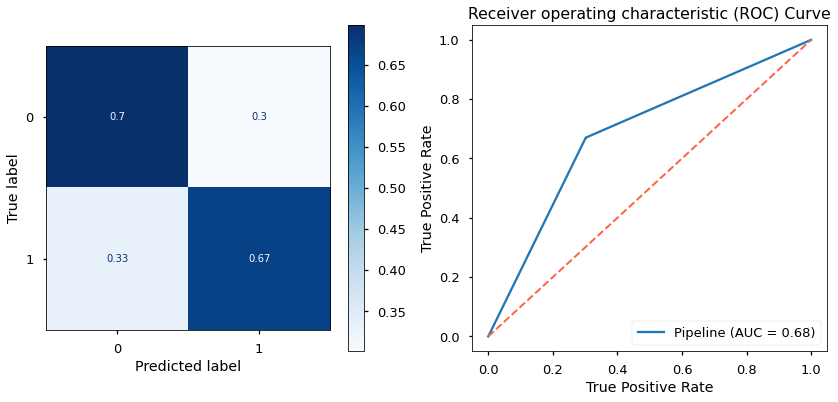

In [311]:
model_evaluation(rf_clf_model, X_test, y_test);

In [746]:
RF_model = Pipeline([
    ("preprocessor", preprocessor),
    ('RF', RandomForestClassifier(random_state=42))
])
# Train model
RF_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_preprocess',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavior...
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ohe',
               



--------------------------------------------------------
Classification Report:
--------------------------------------------------------
              precision    recall  f1-score   support

           0      0.798     0.821     0.809      3634
           1      0.778     0.751     0.765      3043

    accuracy                          0.789      6677
   macro avg      0.788     0.786     0.787      6677
weighted avg      0.789     0.789     0.789      6677

--------------------------------------------------------
--------------------------------------------------------




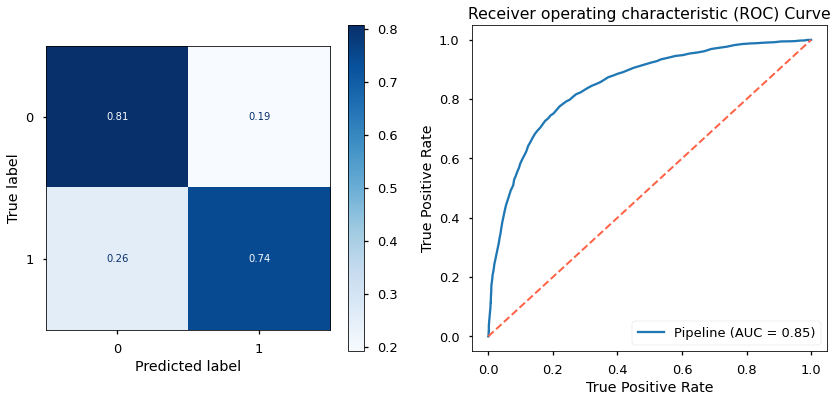

In [314]:
model_evaluation(RF_model, X_test, y_test);

In [742]:
from xgboost import XGBClassifier

xgb_model = Pipeline([
    ("preprocessor", preprocessor),
    ('xgb', XGBClassifier(random_state=0))
])
# Train model
xgb_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_preprocess',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavior...
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_

In [571]:
# Perform k-fold cross validation cross-validation with accuracy
# cross_val_score, returns the score from all k folds. It is generally preferable, but you need to shuffle the data first
score = cross_val_score(estimator=xgb_model, X=X_train,  y=y_train, cv=KFold(n_splits=5, shuffle=True)).mean()
score

# print(f"Mean Cross Validation Score: {scores :.2%}")

# from sklearn.utils import shuffle
# X_s, y_s =shuffle(X_train, y_train)
# scores =cross_val_score(xgb_model, X_s, y_s, cv=10)
# scores.mean()


array([0.76285572, 0.76635047, 0.77783325, 0.75786321, 0.75636545,
       0.76335497, 0.78332501, 0.76385422, 0.7763355 , 0.78132801])

In [574]:
cross_val_score(estimator=xgb_model, X=X_train,  y=y_train, cv=KFold(n_splits=5, shuffle=True))

array([0.77284074, 0.76035946, 0.76809785, 0.7666001 , 0.7763355 ])

In [743]:
xgb_model.score(X_train, y_train)

0.8602096854717923

In [542]:
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

NameError: name 'model_selection' is not defined

In [ ]:
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Comparison between different MLAs')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()